In [1]:
# ------------------------
# Load libraries
# ------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# For preprocessing later
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# ------------------------
# Setup repo and src path
# ------------------------
repo_root = Path("/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository")
src_path = repo_root / "src"
sys.path.append(str(src_path))

In [3]:
# ------------------------
# Step 1: Load and clean dataset
# ------------------------
data_path = Path("../../../Data/adult.csv")  # adjust if your notebook location changes
df = pd.read_csv(data_path)

# Replace '?' with NaN and drop missing values
df.replace("?", np.nan, inplace=True)
missing_counts = df.isna().sum()
print("Columns with missing values:\n", missing_counts[missing_counts > 0])

df_clean = df.dropna()
print("\nShape after cleaning missing values:", df_clean.shape)

# Check target distribution
print("\nTarget distribution:\n", df_clean['income'].value_counts())


Columns with missing values:
 workclass         2799
occupation        2809
native-country     857
dtype: int64

Shape after cleaning missing values: (45222, 15)

Target distribution:
 income
<=50K    34014
>50K     11208
Name: count, dtype: int64


In [5]:
# ------------------------
# Step 2: Preprocessing, encoding, and train/test split
# ------------------------

# Make a copy of the dataframe
df_proc = df_clean.copy()

# Ensure target column exists
if 'income' not in df_proc.columns:
    raise ValueError("Target column 'income' not found in df_clean!")

# Separate features and target before encoding
X_raw = df_proc.drop(columns=['income'])
y = df_proc['income'].apply(lambda x: 0 if x == "<=50K" else 1)  # encode target as 0/1

# One-hot encode categorical variables in features only
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)



Training set shape: (36177, 96) (36177,)
Test set shape: (9045, 96) (9045,)


In [6]:
# ------------------------
# Step 3: Ensemble Method - Random Forest
# ------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # let trees expand fully
    random_state=42,
    n_jobs=-1               # use all cores
)

# Fit model on training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
importances = rf_model.feature_importances_
feature_names = X_encoded.columns
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop 10 features by importance:")
print(feat_imp_df.head(10))


Random Forest Test Accuracy: 0.8480

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6803
           1       0.73      0.62      0.67      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.77      0.78      9045
weighted avg       0.84      0.85      0.84      9045

Confusion Matrix:
[[6291  512]
 [ 863 1379]]

Top 10 features by importance:
                              feature  importance
1                              fnlwgt    0.173035
0                                 age    0.156132
3                        capital-gain    0.101185
5                      hours-per-week    0.084321
28  marital-status_Married-civ-spouse    0.080432
2                     educational-num    0.061108
30       marital-status_Never-married    0.033955
4                        capital-loss    0.032450
55                        gender_Male    0.020597
35         occupation_Exec-manageria

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 0.8605

Tuned Random Forest Test Accuracy: 0.8591


/var/folders/tm/fzd73q8j2_35t_32tbn75vk00000gn/T/ipykernel_22380/2061844773.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')


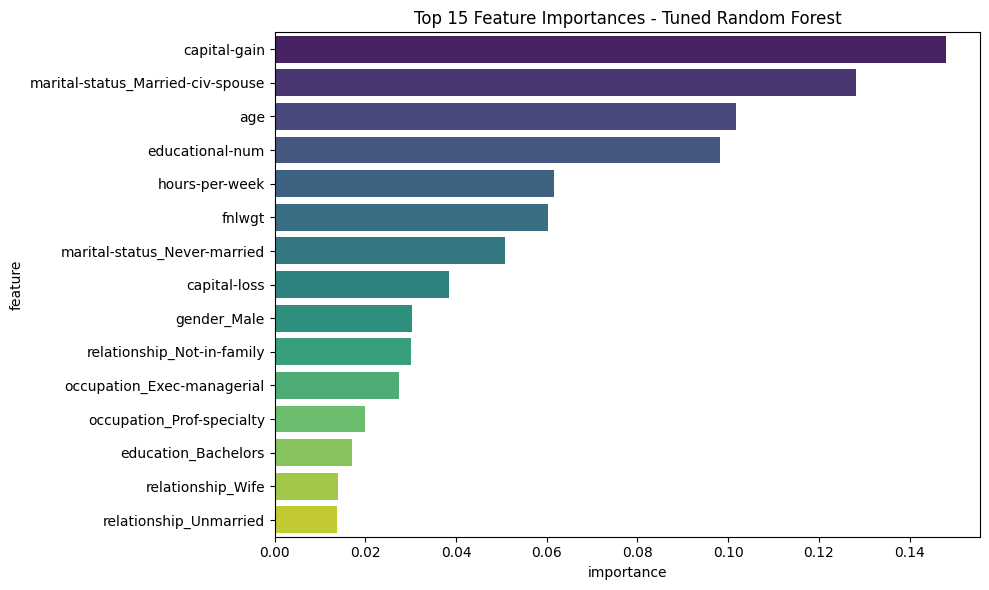

In [7]:
# ------------------------
# Step 4: Random Forest Hyperparameter Tuning & Visualization
# ------------------------

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Simple Grid Search for n_estimators and max_depth
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# Evaluate tuned model on test set
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print(f"\nTuned Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")

# Feature importance visualization
feat_imp = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')
plt.title("Top 15 Feature Importances - Tuned Random Forest")
plt.tight_layout()
plt.show()


In [8]:
# ------------------------
# Step 5: Ensemble Voting Classifier
# ------------------------

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize base models
log_reg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
rand_forest = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None, 
    min_samples_leaf=2, 
    min_samples_split=2,
    random_state=42
)

# Soft voting ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg),
        ('dt', dec_tree),
        ('rf', rand_forest)
    ],
    voting='soft',  # uses predicted probabilities
    n_jobs=-1
)

# Fit ensemble
voting_clf.fit(X_train, y_train)

# Predict on test set
y_pred_ensemble = voting_clf.predict(X_test)

# Evaluate performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Voting Classifier Test Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))


/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X

Voting Classifier Test Accuracy: 0.8544

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6803
           1       0.78      0.57      0.66      2242

    accuracy                           0.85      9045
   macro avg       0.83      0.76      0.78      9045
weighted avg       0.85      0.85      0.85      9045

Confusion Matrix:
[[6439  364]
 [ 953 1289]]


/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [12]:
# ------------------------
# Step 6: Model Performance Summary Table
# ------------------------

import pandas as pd

# Create a performance summary table for all models
performance_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Voting Ensemble'],
    'Test Accuracy': [0.8459, 0.8480, 0.8544],
    'Precision (Class 1)': [0.73, 0.73, 0.78],
    'Recall (Class 1)': [0.60, 0.62, 0.57],
    'F1-score (Class 1)': [0.66, 0.67, 0.66]
})

# Display the table
performance_summary


,Model,Test Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1)
0,Logistic Regression,0.8459,0.73,0.60,0.66
1,Random Forest,0.8480,0.73,0.62,0.67
2,Voting Ensemble,0.8544,0.78,0.57,0.66
